# Generation of local synthetic genomic datasets

This notebook contains the some of the code to process the generated datasets and draw all the plots for the analysis presented in the manuscript.

In [1]:
import pandas as pd 
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
import numpy as np
import pandas as pd
import glob
import os
import warnings
import pyfaidx
warnings.filterwarnings("ignore", "is_categorical_dt")
warnings.filterwarnings("ignore", "use_inf_as_na")                        

In [2]:
! pip install plotnine --quiet
! pip install tqdm --quiet
! pip install celluloid --quiet
from plotnine import *

## Auxiliar functions

Some functions that will be repeatidely used across the notebook.

In [3]:
def load_archive_checkpoints(
    list_of_evolution_directories,
    seeds=(0, 5),
    tags: list = None,
    just_last_generation=False,
):
    archives_full = []
    for j, single_evol in enumerate(list_of_evolution_directories):
        print("Reading directory: ", single_evol)
        df = pd.DataFrame()
        files = [
            f
            for i in range(seeds[0], seeds[1])
            for f in glob.glob(single_evol + f"/*seed_{i}_archive_logger.csv.gz")
        ]

        for file in files:
            _df = pd.read_csv(file)
            _df.Run_id = single_evol.split("/")[-1]
            df = pd.concat([df, _df])

        if tags:
            df["Tag"] = tags[j]

        archives_full.append(df)
    archives_full = pd.concat(archives_full, ignore_index=True)
    archives_full = archives_full.sort_values(by=["Run_id", "Seed", "Generation"])
    archives_full["Time(min)"] = archives_full.Execution_time / 60
    archives_full["Run_id"] = archives_full.Run_id.str.replace(
        "increase_archive_diversity", "IAD"
    )

    if just_last_generation:
        return (
            archives_full.groupby(["Run_id", "Seq_id", "Seed"])
            .apply(lambda x: x.loc[x.Generation.idxmax()])
            .reset_index(drop=True)
        )

    return archives_full

In [4]:
def load_datasets(evolutions: list, tags: list):
    full_datasets = []
    for j, single_evol in enumerate(evolutions):
        print("Reading directory: ", single_evol)

        df = pd.DataFrame()
        files = [f for i in range(30, 60) for f in glob.glob(single_evol + f"/*seed_{i}_dataset.csv.gz")]
        for file in files:
            _df = pd.read_csv(file)
            _df.Run_id = single_evol.split('/')[-1]
            df = pd.concat([df, _df])
        df['Tag'] = tags[j]

        full_datasets.append(df)
    df = pd.concat(full_datasets, ignore_index=True)

    df = df.sort_values(by=['Run_id', 'Seed'])
    df['Run_id'] = df.Run_id.str.replace('increase_archive_diversity', 'IAD')

    return df

## Some general plots

### Lineplots through evolution

In [5]:
import math
sns.set_style("ticks")

def lineplots_through_time(
    _df: pd.DataFrame,
    y: str = "Archive_quality",
    hue: str = "Run_id",
    ylabel: str = None,
    ylim: tuple = None,
    draw_legend_outside: bool = False,
    per_seed: bool = True,
    time_interval: int = 10,
    figsize = (10, 3),
    color_pallette: list = None,
    outfile: str = None
):

    df = _df.copy()
    if color_pallette is None:
        n_colors = df["Run_id"].nunique()
        if len(sns.color_palette("deep")) < n_colors:
            colors = None
        else:
            colors = sns.color_palette("deep")[:n_colors]
    else:
        colors = color_pallette    
    
    if per_seed:
        assert "Time(min)" in df.columns, "df must have a Time(min) column"

        seed_values = df.Seed.unique()
        n_seeds = len(seed_values)
        n_cols = math.ceil(math.sqrt(n_seeds))
        n_rows = (n_seeds - 1) // n_cols + 1

        fig, axes = plt.subplots(n_rows, n_cols, sharey=True, figsize=(figsize[0], figsize[1] * n_rows))
        axes = axes.flatten()

        for i, seed in enumerate(seed_values):
            seed_df = df[df["Seed"] == seed]
            n_colors = seed_df["Run_id"].nunique()
    
            sns.lineplot(
                data=seed_df,
                x="Time(min)",
                y=y,
                hue="Run_id",
                alpha=0.8,
                linewidth=0.1,
                palette=colors,
                ax=axes[i],
                legend=True,
            )
            sns.scatterplot(
                data=seed_df,
                x="Time(min)",
                y=y,
                hue="Run_id",
                legend=False,
                alpha=0.8,
                s=5,
                palette=colors,
                ax=axes[i],
            )
            axes[i].set_title(f"Seed {seed}")
            axes[i].set_xlabel("Time (min)")
            axes[i].set_ylabel(f'{y.replace("_", " ")}')

        for j in range(i + 1, n_rows * n_cols):
            fig.delaxes(axes[j])

        handles, labels = axes[0].get_legend_handles_labels()
        for line in handles:
            line.set_linewidth(2.0)
        fig.legend(handles, labels, bbox_to_anchor=(1.25, 1))
        for ax in axes:
            try:
                ax.get_legend().remove()
            except AttributeError:
                pass

        fig.subplots_adjust(hspace=0.95, wspace=0.1)
        plt.tight_layout()
        plt.show()
        plt.close()

    else:
                
        df["Time_intervals"] = pd.cut(
            df["Time(min)"] * 60,
            bins=np.arange(
                0, (df["Time(min)"].max() * 60) + time_interval, time_interval
            ),
        )
        df['Time(min)'] = df['Time_intervals'].apply(lambda interval: (interval.left + interval.right) / 2)
        df['Time(min)'] = df['Time(min)'].astype(float) / 60
        fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
        sns.lineplot(x="Time(min)", y=y,
             hue=hue, errorbar='sd', 
            # estimator=np.median,
             data=df, markers=True, ax=ax, palette=colors)

        
        if ylabel is None:
            ylabel = y.replace("_", " ")
        ax.set_ylabel(ylabel)
        ax.get_legend().set_title(None)
        
        if draw_legend_outside:
            plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1), fontsize=7)
        
        if ylim is not None:
            ax.set_ylim(ylim)
        
        plt.xticks(np.arange(0, 5.1, 1))
        
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")
    plt.show()
    plt.close()

In [6]:
def lineplots(
    df: pd.DataFrame,
    x: str = "Generation",
    y: str = "Archive_size",
    metric: str = "mean",
    color_pallette: list = None,
    figsize=(5, 4),
    outfile: str = None,
):
    """
    Draw lineplots of the evolution of the archive through a discrete variable, by default the generation number.

    Args:
        df (pd.DataFrame): Dataframe with the data to plot.
        x (str, optional): Column to plot in X axis. Defaults to 'Generation'.
        y (str, optional): Column to plot in Y axis. Defaults to 'Archive_size'.
        metric (str, optional): Metric to aggregate the y column across seeds. Defaults to 'mean'.
    """
    assert (
        "Time" not in x
    ), "To plot through time, use 'lineplots_through_time' function"

    if color_pallette is None:
        n_colors = df["Run_id"].nunique()
        if len(sns.color_palette("deep")) < n_colors:
            colors = None
        else:
            colors = sns.color_palette("deep")[:n_colors]
    else:
        colors = color_pallette

    groupby_cols = ["Run_id", x]
    archive_stats = df.groupby(groupby_cols)[y].agg([metric, "std"]).reset_index()

    fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
    sns.lineplot(
        data=df,
        x=x,
        y=y,
        errorbar="sd",
        hue="Run_id",
        alpha=0.8,
        linewidth=0.5,
        palette=colors,
        ax=ax,
    )
    sns.scatterplot(
        data=archive_stats,
        x=x,
        y=metric,
        hue="Run_id",
        legend=False,
        alpha=0.8,
        s=20,
        palette=colors,
        ax=ax,
    )
    legend = plt.legend(loc="upper right", bbox_to_anchor=(1.7, 1))
    for line in legend.get_lines():
        line.set_linewidth(2.0)
    plt.ylabel(f'{y.replace("_", " ")}')

    if outfile:
        plt.savefig(outfile, bbox_inches="tight")
    plt.show()
    plt.close()        

In [7]:
def facet_lineplot(df, by, n_cols=1, outfile: str = None, **kwargs):
    g = sns.FacetGrid(df, col=by, col_wrap=n_cols, sharey=False, sharex=True, height=1.5)
    df["Time_intervals"] = pd.cut(
        df["Time(min)"] * 60,
        bins=np.arange(
            0, (df["Time(min)"].max() * 60) + kwargs['time_interval'], kwargs['time_interval']
        ),
    )
    df['Time(min)'] = df['Time_intervals'].apply(lambda interval: (interval.left + interval.right) / 2)
    df['Time(min)'] = df['Time(min)'].astype(float) / 60
    g.map_dataframe(
        sns.lineplot,
        data=df,
        x='Time(min)',
        hue='Tag',
        y='Value',
        errorbar='sd',
        palette=kwargs['color_pallette'],
    )
    g.set(xlim=(0, 10), ylim=(0, None))
    g.axes[0].set_ylim(0, 1)
    g.axes[1].set_ylim(0, 5000)
    g.axes[2].set_ylim(0, 1)
    g.set_titles("{col_name}", size=7)
    g.set_xticklabels(size=7)
    g.set_yticklabels(size=7)
    g.set_axis_labels("", "")
    plt.legend(loc='upper right', bbox_to_anchor=(2, 1.1), ncol=1, fontsize=7)
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")
    plt.show()
    plt.close()

### Performance boxplot

In [8]:
def draw_boxplot(
    df: pd.DataFrame,
    x: str,
    y: str,
    ylabel: str,
    xlabel: str = None,
    color_pallette: list = None,
    do_statistical_test: bool = True,
    title: str = None,
    xlim: tuple = None,
    ylim: tuple = None,
    figsize: tuple = (3, 3),
    include_xlabels: bool = True,
    x_label_rotation: int = 45,
    legend_outside: bool = False,
    outfile: str = None
):

    fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
    ax = sns.stripplot(
        data=df,
        x=x,
        hue=x,
        y=y,
        palette=color_pallette,
        linewidth=0.25,
        edgecolor="black",
        color="grey",
        alpha=0.4,
        legend=False,
        dodge=False,
    )
    sns.boxplot(
        data=df,
        x=x,
        hue=x,
        y=y,
        boxprops=dict(alpha=0.9),
        palette=color_pallette,
        showfliers=False,
        legend=False,
        zorder=10,
        ax=ax
    )

    # Do test
    if do_statistical_test:

        pairs = [
            ("GGGP_BF", "RS_BF"),
            ("GGGP_IAD", "RS_IAD"),
            ("GGGP_BF", "GGGP_IAD"),
        ]
        p_vals = []
        
        for pair in pairs:
            grp1 = df[df.Run_id == pair[0]].Archive_quality
            grp2 = df[df.Run_id == pair[1]].Archive_quality

            _, p_val = stats.ttest_ind(grp1, grp2, equal_var=False)
            p_vals.append(p_val)

        # Apply Bonferroni correction
        num_tests = len(pairs)
        adj_p_vals = [p * num_tests for p in p_vals] 
        
        # Annotate
        ids = {"GGGP_BF": 0, "RS_BF": 1, "GGGP_IAD": 2, "RS_IAD": 3}
        to_add = 0
        for i, p in enumerate(pairs):
            x1, x2 = ids[p[0]], ids[p[1]]
            y, h, col = df.Archive_quality.max() + 0.005, 0.005, "k"

            plt.plot(
                [x1, x1, x2, x2],
                [y + to_add, y + h + to_add, y + h + to_add, y + to_add],
                lw=0.5,
                c=col,
            )
            pvalue = adj_p_vals[i]
            if pvalue > 0.0001:
                pvalue = str(round(pvalue, 4))
            else:
                pvalue = str(format(pvalue, ".2e"))
            plt.text((x1 + x2) * 0.5, y + h + to_add, f'p={pvalue}', ha="center", va="bottom", color=col, fontsize=7)
            to_add += 0.0075
        plt.ylim(0.73, 1.03)
        
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=8)
    else:
        ax.set_xlabel("")
    
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=8)
    
    ax.tick_params(axis='y', which='major', labelsize=8)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f"))
    
    if include_xlabels is False:
        ax.set_xticklabels([])
        ax.set_xticks([])
    else:
        ax.tick_params(axis='x', which='major', labelsize=8, rotation=x_label_rotation)
        #ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize': 9}, rotation=x_label_rotation)#, ha="right")
    
    if title:
        ax.set_title(title, fontsize=9)
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    if legend_outside:
        ax.legend(bbox_to_anchor=(1.1, 0.9), ncol=1, fontsize=8)
            
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    plt.close()

In [9]:
def facet_boxplot(df, by, **kwargs):
    g = sns.FacetGrid(df, col=by, col_wrap=3, sharey=False, sharex=True, height=2)
    g.map_dataframe(
        sns.boxplot,
        data=df,
        x='Tag',
        hue='Tag',
        y='Value',
        boxprops=dict(alpha=0.9),
        palette=kwargs['color_pallette'],
        showfliers=False,
        legend=False,
        zorder=10
    )
    
    g.set_titles("{col_name}", size=9)
    g.set_axis_labels("", "")
    g.set_xticklabels(size=9)
    g.set_yticklabels(size=9)
    plt.tight_layout()
    plt.show()
    plt.close()

### Scatterplot

In [10]:
def draw_scatterplot(
    df: pd.DataFrame,
    x: str,
    y: str,
    xlabel: str,
    ylabel: str,
    color_pallette: list,
    hue: str = 'Tag',
    title: str = None,
    xlim: tuple = None,
    ylim: tuple = None,
    alpha: float = 0.85,
    figsize: tuple = (3, 2.5),
    legend_outside: bool = False,
    draw_horizontal_line: bool = False,
    outfile: str = None
):
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue=hue,
        edgecolor='k',
        linewidth=0.25,
        alpha=alpha,
        palette=color_pallette,
        ax=ax
    )
    ax.set_xlabel(xlabel, fontsize=9)
    ax.set_ylabel(ylabel, fontsize=9)
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    legend = ax.legend()
    legend.set_title(None) 
    ax.tick_params(axis='both', which='major', labelsize=9) 
    if title:
        ax.set_title(title, fontsize=10)
    
    if legend_outside:
        ax.legend(bbox_to_anchor=(1.1, 0.9), ncol=1, fontsize=9)
    
    if draw_horizontal_line:
        mean_values = df.groupby('Tag')[y].median()

        for tag, mean in mean_values.items():
            ax.axhline(mean, color=color_pallette[df['Tag'].unique().tolist().index(tag)], linestyle='--', alpha=0.65)
            
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, bbox_inches='tight')
    plt.show()

### Bin-based barplot

In [11]:
def per_bin_filling_stacked_barplot(
    df: pd.DataFrame,
    color_pallette: list,
    filter_by: float = None,
    figsize=(7, 2.5),
    draw_legend: bool = True,
    outfile: bool = False,
):
    df = df.copy()

    if filter_by:
        df = df[df.Bin > filter_by]

    grouped_df = df.groupby(["Bin", "Tag"])["Count"].agg(["mean", "std"]).reset_index()

    pivot_df = grouped_df.pivot(index="Bin", columns="Tag", values="mean").fillna(0)
    pivot_df.plot.bar(
        stacked=True,
        edgecolor="k",
        figsize=figsize,
        linewidth=0.5,
        color=color_pallette,
    )
    plt.tick_params(axis="both", which="major", labelsize=7)
    plt.legend(loc="upper right", bbox_to_anchor=(1.22, 1), ncol=1, fontsize=7)
    plt.xticks(rotation=65)
    if draw_legend is False:
        plt.legend().remove()
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def per_bin_filling_lineplot(
    df: pd.DataFrame,
    color_pallette: list,
    filter_by: float = None,
    figsize=(7, 2.5),
    draw_legend: bool = True,
    outfile: bool = False,
):
    df = df.copy()

    if filter_by:
        df = df[df.Bin > filter_by]

    grouped_df = df.groupby(["Bin", "Tag"])["Count"].agg(["mean", "std"]).reset_index()
    pivot_df = grouped_df.pivot(index="Bin", columns="Tag", values="mean").fillna(0)
    
    plt.figure(figsize=figsize)
    for tag, color in zip(pivot_df.columns, color_pallette):
        plt.plot(pivot_df.index, pivot_df[tag], label=tag, color=color, marker='o', markersize=3, alpha=0.8)

    plt.xlabel("Bin ID")
    plt.ylabel("Counts")
    plt.tick_params(axis="both", which="major", labelsize=7)
    plt.xticks(pivot_df.index, rotation=65)

    plt.axvline(x=0.9, color='gray', linestyle='--', linewidth=1)
    plt.ylim(bottom=0)
    if draw_legend:
        plt.legend(ncol=1, fontsize=8)#loc="upper right", bbox_to_anchor=(1.22, 1))
    else:
        plt.legend().remove()
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")
    plt.show()


## 1 - Hyperparameter optmimization

After running hyperopt with Optuna (via `scripts/0_optuna_optimizaton.py`, using a single seed), best 5 trials for each configuration were extracted and automatically subjected to 5 rounds of evolution using different seeds to find the most stable configuration (via `scripts/1_extract_best_trials.py`, that automatically launches the slurm jobs). 

Here, this section of the notebook explores the results of the top 5 trials for each configuration (GGGP_BinFiller, GGGP_IAD, RandomSearch_BinFiller, RandomSearch_IAD) to see some general patterns of the evolutionary search.

Finally, the script `scripts/2_analyse_best_trials.py` averages results across seeds and returns a ranked description of the best trials, that serves as the basis to select the best parameter set for each configuration.

In [15]:
DATASETS_PATH = '1_hyperparameter_search/1_bestTrialsMultipleSeeds/'
evolutions = list(filter(lambda f: os.path.isdir(os.path.join(DATASETS_PATH, f)), os.listdir(DATASETS_PATH)))
evolutions = [os.path.join(DATASETS_PATH, d) for d in evolutions]
archives_full = load_archive_checkpoints(evolutions)

Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_1_trial428
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_2_trial461
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_3_trial466
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_4_trial484
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_5_trial498
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_random_1_trial289
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_random_2_trial290
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_random_3_trial298
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_random_4_trial312
Reading directory:  1_hyperparameter_search/1_bestTrialsMultipleSeeds/bin_filler_random_5_trial447
Reading directory:  1_hyperparameter_search/1

### Archive metrics during the course of evolution

Measuring some properties of the Archive through evolution with a reduced version of the Archive logger, which just reports some overal metrics of the archive at each generation

In [16]:
# With RS string
archives = archives_full.copy()
archives["Run_id"] = archives.Run_id.str.replace(r"^bin_filler_random", "RS_BF", regex=True)
archives["Run_id"] = archives.Run_id.str.replace(r"^IAD_random", "RS_IAD", regex=True)
archives["Run_id"] = archives.Run_id.str.replace(r"^bin_filler", "GGGP_BF", regex=True)
archives["Run_id"] = archives.Run_id.str.replace(r"^IAD", "GGGP_IAD", regex=True)
archives["Run_id"] = archives.Run_id.str.replace(r"_[1-5]", "", regex=True)
archives["Run_id"] = archives.Run_id.str.replace(r"_trial", "_", regex=True)
archives["Run_id"] = pd.Categorical(
    archives.Run_id,
    categories=["GGGP_BF_428",  "GGGP_BF_461", "GGGP_BF_466", "GGGP_BF_484", "GGGP_BF_498", 
                "GGGP_IAD_218", "GGGP_IAD_380",  "GGGP_IAD_381", "GGGP_IAD_450", "GGGP_IAD_459",
                "RS_BF_289", "RS_BF_290", "RS_BF_298", "RS_BF_312", "RS_BF_447",
                "RS_IAD_123", "RS_IAD_132", "RS_IAD_138", "RS_IAD_168", "RS_IAD_225"
                ],
    ordered=True,
)

In [17]:
# Define color palettes
blue = sns.color_palette("Blues")[1:6]
red = sns.dark_palette((20, 60, 50), input="husl")[1:6]
green = sns.light_palette("seagreen")[1:6]
gold = sns.dark_palette("xkcd:golden", 8)[3:8]
color_pallette = blue + red + green + gold

#### Archive quality

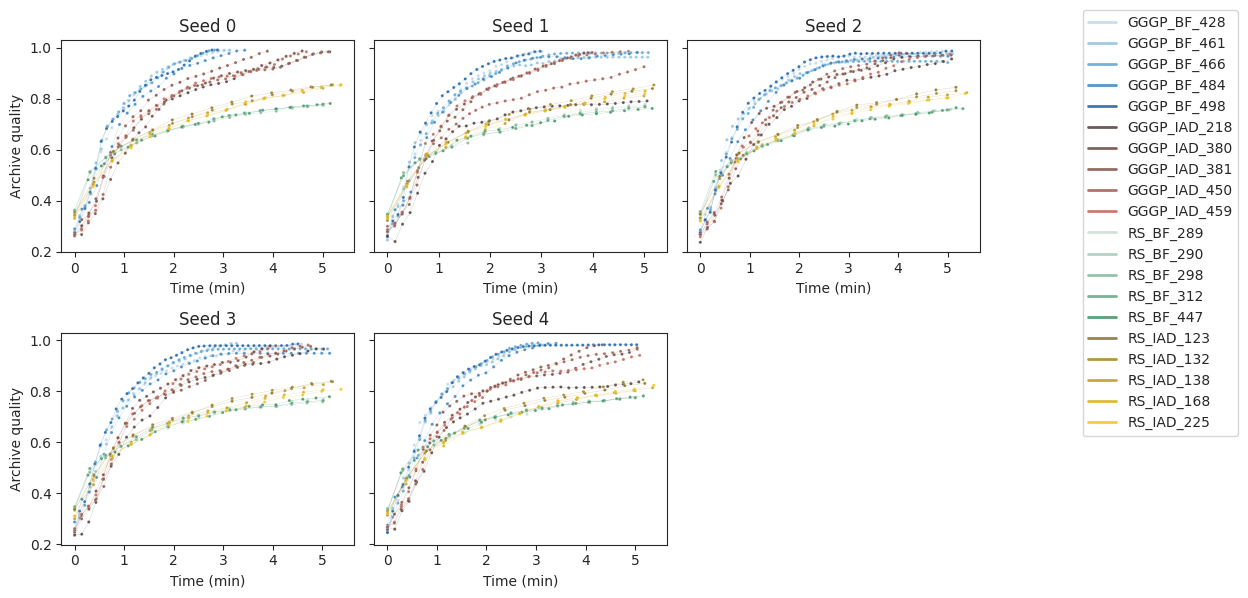

In [18]:
lineplots_through_time(archives, y='Archive_quality', color_pallette=color_pallette)

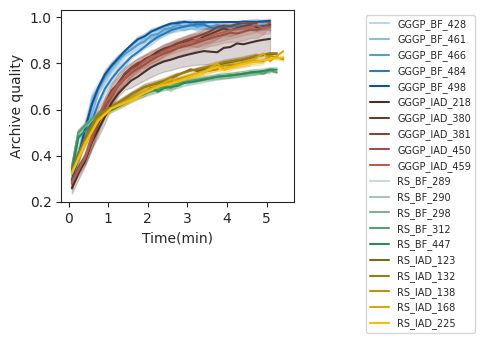

In [19]:
lineplots_through_time(
    archives,
    y="Archive_quality",
    figsize=(3, 2.5),
    time_interval=10,
    per_seed=False,
    color_pallette=color_pallette,
    draw_legend_outside=True,
    outfile='fig2_best5_through_evolution.pdf'
)

/tmp/ipykernel_1669498/630215312.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


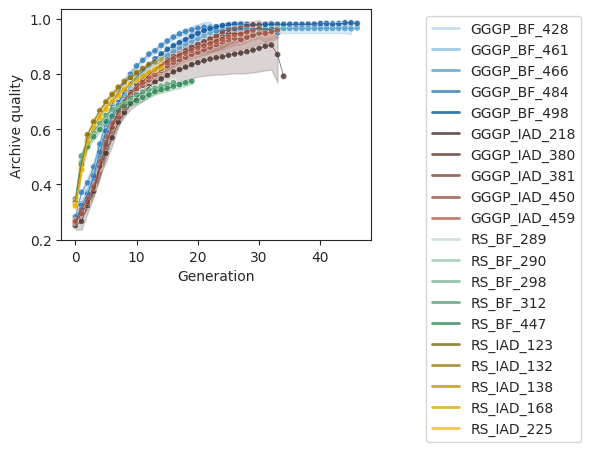

In [20]:
lineplots(archives, y="Archive_quality",
          color_pallette=color_pallette,
        figsize=(4, 3),)

#### Archive diversity

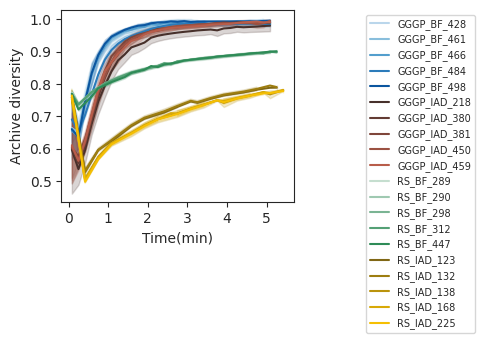

In [21]:
lineplots_through_time(
    archives,
    per_seed=False,
    y="Archive_diversity",
    figsize=(3, 2.5),
    draw_legend_outside=True,
    color_pallette=color_pallette,
)

#### Archive diversity per bin

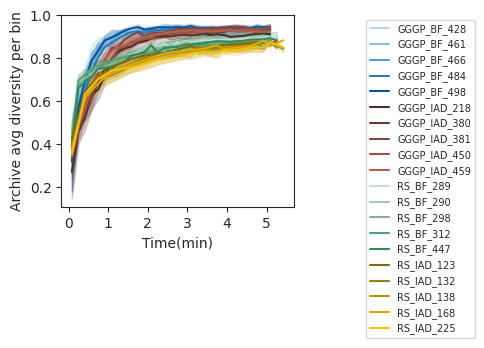

In [22]:
lineplots_through_time(
    archives,
    per_seed=False,
    time_interval=10,
    figsize=(3, 2.5),
    draw_legend_outside=True,
    y="Archive_avg_diversity_per_bin",
    color_pallette=color_pallette,
)

#### Low count bin ratio

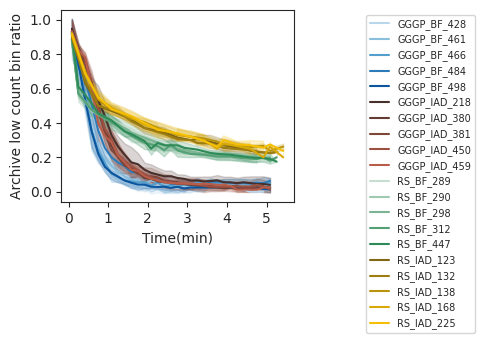

In [23]:
lineplots_through_time(
    archives,
    per_seed=False,
    time_interval=10,
    figsize=(3, 2.5),
    draw_legend_outside=True,
    y="Archive_low_count_bin_ratio",
    color_pallette=color_pallette,
)

#### Avg number of diff units

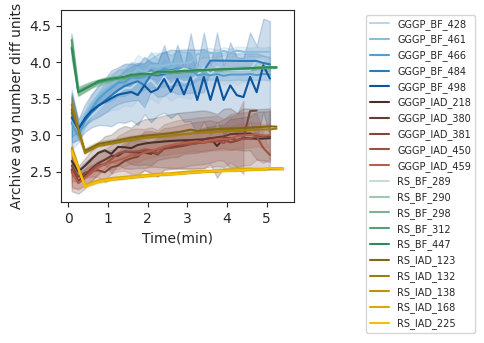

In [24]:
lineplots_through_time(
    archives,
    per_seed=False,
    y="Archive_avg_number_diff_units",
    figsize=(3, 2.5),
    draw_legend_outside=True,
    color_pallette=color_pallette,
)

#### Avg edit distance

In [25]:
subset = archives[archives.Run_id.str.contains("GGGP")].copy()
subset["Run_id"] = pd.Categorical(
    subset.Run_id,
    categories = ["GGGP_BF_428",  "GGGP_BF_461", "GGGP_BF_466", "GGGP_BF_484", "GGGP_BF_498", "GGGP_IAD_218", "GGGP_IAD_380","GGGP_IAD_381", "GGGP_IAD_450", "GGGP_IAD_459"],
    ordered=True,
)

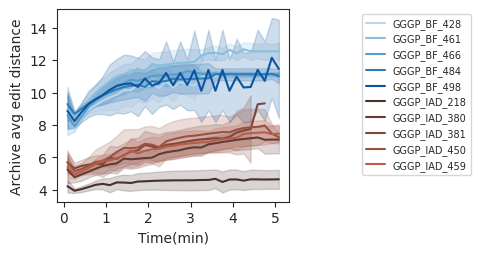

In [26]:
lineplots_through_time(
    subset,
    per_seed=False,
    time_interval=10,
    y="Archive_avg_edit_distance",
    color_pallette=color_pallette[:10],
    figsize=(3, 2.5),
    draw_legend_outside=True,
)

## 2 - Performance comparison

From the best configuration for each strategy, we measured the quality of the final archives.

In [13]:
DATASETS_PATH = '2_performanceComparison/1_bestConfiguration30Seeds/'
evolutions = list(filter(lambda f: os.path.isdir(os.path.join(DATASETS_PATH, f)), os.listdir(DATASETS_PATH)))
evolutions = [os.path.join(DATASETS_PATH, d) for d in evolutions if 'with' not in d]
archives = load_archive_checkpoints(evolutions, seeds=(30, 60), just_last_generation=True)

Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_1_trial428
Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_random_5_trial447
Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/increase_archive_diversity_3_trial381
Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/increase_archive_diversity_random_2_trial132


In [28]:
archives['Fitness_function'] = archives.Run_id.apply(lambda x: 'BinFiller' if 'bin_filler' in x else 'IAD')
archives['Tag'] = archives.Run_id.apply(lambda x: 'BestRandom' if 'random' in x else 'BestConfig')
archives["Run_id"] = archives.Run_id.str.replace(r"_[1-5]", "", regex=True)
archives["Run_id"] = archives.Run_id.replace({'bin_filler_trial428': 'GGGP_BF',
                                              'bin_filler_random_trial447': 'RS_BF',
                                              'IAD_trial381': 'GGGP_IAD',
                                              'IAD_random_trial132': 'RS_IAD'})

archives["Run_id"] = pd.Categorical(
    archives.Run_id,
    categories=["GGGP_BF", "RS_BF", "GGGP_IAD", "RS_IAD"],
    ordered=True,
)

archives["Fitness_function"] = pd.Categorical(
    archives.Fitness_function,
    categories=["BinFiller", "IAD"],
    ordered=True,
)
archives["Tag"] = pd.Categorical(
    archives.Tag,
    categories=["BestConfig", "BestRandom"],
    ordered=True,
)

In [29]:
# Define color palettes
blue = [sns.color_palette("Blues")[3]]
red = [sns.dark_palette((20, 60, 50), input="husl")[3]]
green = [sns.light_palette("seagreen")[3]]
gold = [sns.dark_palette("xkcd:golden", 8)[6]]
color_pallette = blue + green + red + gold

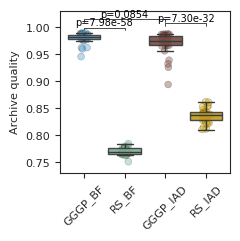

In [30]:
draw_boxplot(
    archives,
    x="Run_id",
    y="Archive_quality",
    ylabel="Archive quality",
    color_pallette=color_pallette,
    do_statistical_test=True,
    figsize=(2.5, 2.5),
    outfile='fig2_perf_welch_test.pdf'
)

#### Inspect the fitness functions

The results from Optuna for GGGP with IAD as fitness function displayed a bit of too extreme best parameters.
To test whether Optuna for IAD did not run optimally, we run 30 extra evolutions using the best params found when using BinFiller, but replaced the fitness function to be IAD. Results show that this IAD configuration presents better results than the best one found by optuna

In [34]:
DATASETS_PATH = '2_performanceComparison/1_bestConfiguration30Seeds/'
evolutions = list(filter(lambda f: os.path.isdir(os.path.join(DATASETS_PATH, f)), os.listdir(DATASETS_PATH)))
evolutions = [os.path.join(DATASETS_PATH, d) for d in evolutions if 'random' not in d]
archives = load_archive_checkpoints(evolutions, seeds=(30, 60), just_last_generation=True)

Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_1_trial428
Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/increase_archive_diversity_3_trial381
Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/with_IAD_and_best_BF_params
Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/with_BF_and_best_IAD_params


In [35]:
archives['Fitness_function'] = archives.Run_id.apply(lambda x: 'BinFiller' if 'bin_filler' in x else 'IAD')
archives['Tag'] = archives.Run_id.apply(lambda x: 'BestRandom' if 'random' in x else 'BestConfig')
archives["Run_id"] = archives.Run_id.str.replace(r"_[1-5]", "", regex=True)
archives["Run_id"] = archives.Run_id.replace({'bin_filler_trial428': 'BF',
                                              'IAD_trial381': 'IAD',
                                              'with_IAD_and_best_BF_params': 'IAD_BFsetup',
                                              'with_BF_and_best_IAD_params': 'BF_IADsetup'})

archives["Run_id"] = pd.Categorical(
    archives.Run_id,
    categories=["BF", "IAD_BFsetup", "IAD", "BF_IADsetup"],
    ordered=True,
)

In [36]:
# Define color palettes
blue = [sns.color_palette("Blues")[idx] for idx in [2, 5]]
red = [sns.dark_palette((20, 60, 50), input="husl")[idx] for idx in [2, 5]]
color_pallette = blue + red

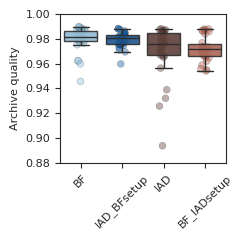

In [37]:
draw_boxplot(
    archives,
    x="Run_id",
    y="Archive_quality",
    ylabel="Archive quality",
    color_pallette=color_pallette,
    do_statistical_test=False,
    figsize=(2.5, 2.5),
    ylim=(0.88, 1),
    outfile="suppfig1_check_ff_perf.pdf"
)

In [20]:
archives.groupby('Run_id').Archive_quality.median()

/tmp/ipykernel_1791455/4031119344.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Run_id
BF                    0.98125
BF_with_IAD_params    0.97145
IAD                   0.97545
IAD_with_BF_params    0.98030
Name: Archive_quality, dtype: float64

In [38]:
archives = load_archive_checkpoints(evolutions, seeds=(30, 60), just_last_generation=False)
archives['Fitness_function'] = archives.Run_id.apply(lambda x: 'BinFiller' if 'bin_filler' in x else 'IAD')
archives['Tag'] = archives.Run_id.apply(lambda x: 'BestRandom' if 'random' in x else 'BestConfig')
archives["Run_id"] = archives.Run_id.str.replace(r"_[1-5]", "", regex=True)
archives["Run_id"] = archives.Run_id.replace({'bin_filler_trial428': 'BF',
                                              'IAD_trial381': 'IAD',
                                              'with_IAD_and_best_BF_params': 'IAD_BFsetup',
                                              'with_BF_and_best_IAD_params': 'BF_IADsetup'})

archives["Run_id"] = pd.Categorical(
    archives.Run_id,
    categories=["BF", "IAD_BFsetup", "IAD", "BF_IADsetup"],
    ordered=True,
)

Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_1_trial428
Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/increase_archive_diversity_3_trial381
Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/with_IAD_and_best_BF_params
Reading directory:  2_performanceComparison/1_bestConfiguration30Seeds/with_BF_and_best_IAD_params


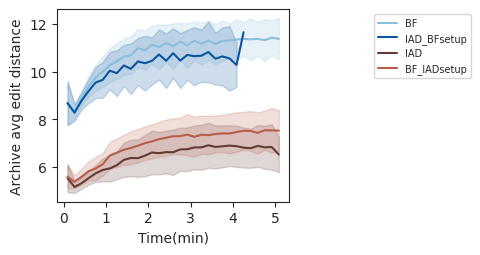

In [39]:
lineplots_through_time(
    archives,
    per_seed=False,
    time_interval=10,
    y="Archive_avg_edit_distance",
    color_pallette=color_pallette[:10],
    figsize=(3, 2.5),
    draw_legend_outside=True,
    outfile="suppfig1_check_ff_edit_dist.pdf"
)

## 3 - Ablation studies

Study the impact of several components of the GGGP strategy in the final archive quality.

In [13]:
BEST_CONFIG_PATH = os.path.join(os.getcwd(), '2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_1_trial428/')
LEXICASE_PATH = os.path.join('3_ablationStudies', '1_lexicase')
CUSTOM_MUTATION_PATH = os.path.join('3_ablationStudies', '2_customMutationOperator')
GRAMMAR_NODES_PATH = os.path.join('3_ablationStudies', '3_grammarNodeTypes')

list_dirs = lambda path: [os.path.join(path, f) for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
EVOLUTIONS = [[BEST_CONFIG_PATH, LEXICASE_PATH]]

for path in [CUSTOM_MUTATION_PATH, GRAMMAR_NODES_PATH]:
    paths = [BEST_CONFIG_PATH]
    dir_list = list_dirs(path)
    paths = paths + dir_list
    EVOLUTIONS.append([os.path.join(os.getcwd(),  p) for p in sorted(paths)])

### Lexicase selection

In [14]:
LEXICASE_DF = load_archive_checkpoints(
    EVOLUTIONS[0],
    seeds = (30, 60),
    just_last_generation = False,
    tags = ["BestConfig", "Lexicase"],
)

LEXICASE_DF_LAST_GEN = load_archive_checkpoints(
    EVOLUTIONS[0],
    seeds = (30, 60),
    just_last_generation = True,
    tags = ["BestConfig", "Lexicase"],
)

Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_1_trial428/
Reading directory:  3_ablationStudies/1_lexicase
Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_1_trial428/
Reading directory:  3_ablationStudies/1_lexicase


In [15]:
# Define color palettes
blue = [sns.color_palette("Blues")[3]]
red = [sns.dark_palette((20, 60, 50), input="husl")[3]]
color_pallette = blue + red

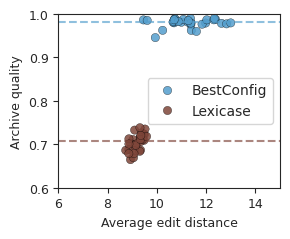

In [19]:
draw_scatterplot(
    LEXICASE_DF_LAST_GEN,
    x="Archive_avg_edit_distance",
    y="Archive_quality",
    xlabel="Average edit distance",
    ylabel="Archive quality",
    color_pallette=color_pallette,
    xlim=(6, 15),
    ylim=(0.6, 1), 
    draw_horizontal_line=True,
    outfile='fig4_scatterplot_lexicase.pdf'
    
)

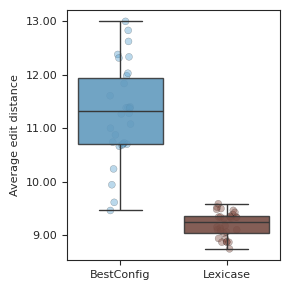

In [45]:
draw_boxplot(
    LEXICASE_DF_LAST_GEN,
    x="Tag",
    y="Archive_avg_edit_distance",
    ylabel="Average edit distance",
    do_statistical_test=False,
    x_label_rotation=0,
    color_pallette=color_pallette,
)

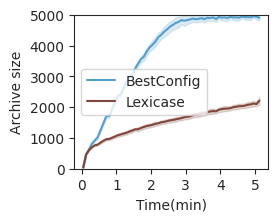

In [46]:
lineplots_through_time(
    LEXICASE_DF,
    y="Archive_size",
    hue="Tag",
    per_seed=False,
    ylabel='Archive size',
    ylim=(0,5000),
    time_interval=5,
    figsize=(2.5, 2),
    color_pallette=color_pallette,
    outfile='fig4_lineplot_lexicase.pdf'
)

In [47]:
MELTED = pd.melt(
    LEXICASE_DF,
    id_vars=["Tag", "Time(min)"],
    value_vars=[
        "Archive_quality",
        "Archive_size",
        "Archive_diversity",
        "Archive_avg_diversity_per_bin",
        "Archive_low_count_bin_ratio",
        "Archive_avg_number_diff_units",
        "Archive_avg_edit_distance",
    ],
    var_name="Metric",
    value_name="Value",
)

MELTED_LAST_GEN = pd.melt(
    LEXICASE_DF_LAST_GEN,
    id_vars=["Tag"],
    value_vars=[
        "Archive_quality",
        "Archive_size",
        "Archive_diversity",
        "Archive_avg_diversity_per_bin",
        "Archive_low_count_bin_ratio",
        "Archive_avg_number_diff_units",
        "Archive_avg_edit_distance",
    ],
    var_name="Metric",
    value_name="Value",
)

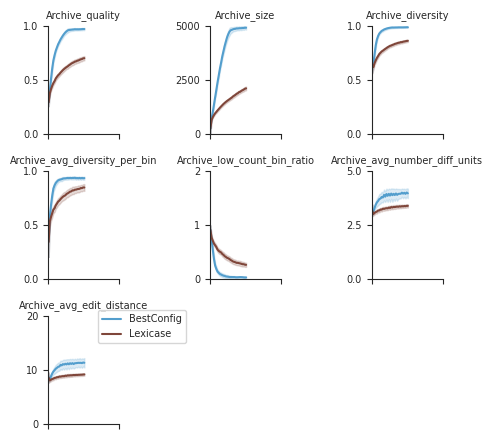

In [48]:
facet_lineplot(
    MELTED, by="Metric", n_cols=3, time_interval=10, color_pallette=color_pallette
)

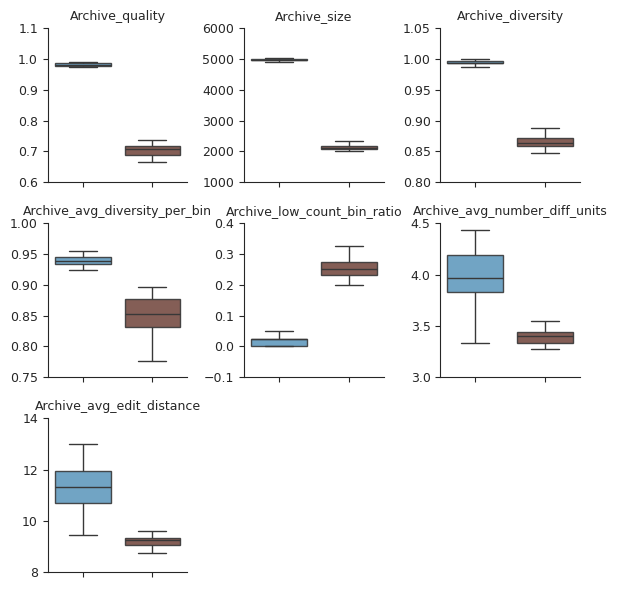

In [49]:
facet_boxplot(MELTED_LAST_GEN, by="Metric", color_pallette=color_pallette)

### Custom mutation operator

In [20]:
CUSTOM_MUTATION_DF_LAST_GEN = load_archive_checkpoints(
    EVOLUTIONS[1],
    seeds = (30, 60),
    just_last_generation = True,
    tags = ["BestConfig", "0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.9", "1.0"],
)

CUSTOM_MUTATION_DF_LAST_GEN["Tag"] = pd.Categorical(
    CUSTOM_MUTATION_DF_LAST_GEN.Tag,
    categories=['1.0', '0.9', 'BestConfig', '0.7', '0.6', '0.5', '0.4', '0.3', '0.2', '0.1', '0'],
    ordered=True,
)

Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_1_trial428/
Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/3_ablationStudies/2_customMutationOperator/weight_0
Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/3_ablationStudies/2_customMutationOperator/weight_0.1
Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/3_ablationStudies/2_customMutationOperator/weight_0.2
Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/3_ablationStudies/2_customMutationOperator/weight_0.3
Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/3_ablationStudies/2_customMutationOperator/weight_0.4
Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/3_ablationStudies/2_customMutationOperator/weight_0.5
Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/3_ab

In [21]:
# Define color palettes
blue = [sns.color_palette("Blues")[3]]
red = sns.dark_palette((20, 60, 50), input="husl", n_colors=12)[2:]
color_pallette = red[0:2] + blue + red[2:] 

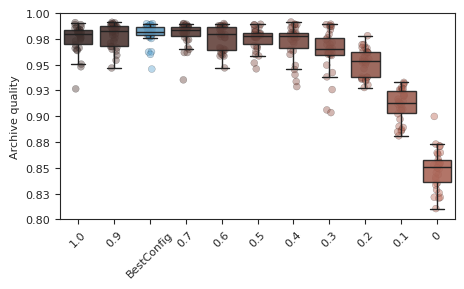

In [22]:
draw_boxplot(
    CUSTOM_MUTATION_DF_LAST_GEN,
    x="Tag",
    y="Archive_quality",
    ylabel="Archive quality",
    figsize=(4.75, 3),
    ylim=(0.80, 1),
    include_xlabels=True,
    x_label_rotation=45,
    color_pallette=color_pallette,
    do_statistical_test=False,
    outfile='fig5_boxplot_custom_mutation.pdf'
)

### Grammar nodes

In [23]:
GRAMMAR_NODES_DF = load_archive_checkpoints(
    EVOLUTIONS[2],
    seeds = (30, 60),
    just_last_generation = False,
    tags = ["BestConfig", "NoDels", "NoDelsAndIns", "NoIns"],
)

GRAMMAR_NODES_DF_LAST_GEN = load_archive_checkpoints(
    EVOLUTIONS[2],
    seeds = (30, 60),
    just_last_generation = True,
    tags = ["BestConfig", "NoDels", "NoDelsAndIns", "NoIns"],
)

GRAMMAR_NODES_DF_LAST_GEN["Tag"] = pd.Categorical(
    GRAMMAR_NODES_DF_LAST_GEN.Tag,
    categories=["BestConfig", "NoDels", "NoIns", "NoDelsAndIns"],
    ordered=True,
)

GRAMMAR_NODES_FULL_DATASETS = load_datasets(EVOLUTIONS[2], ['BestConfig', 'NoDels', 'NoDelsAndIns', 'NoIns'])

Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_1_trial428/
Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/3_ablationStudies/3_grammarNodeTypes/noDeletions
Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/3_ablationStudies/3_grammarNodeTypes/noDeletionsAndInsertions
Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/3_ablationStudies/3_grammarNodeTypes/noInsertions
Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/2_performanceComparison/1_bestConfiguration30Seeds/bin_filler_1_trial428/
Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/3_ablationStudies/3_grammarNodeTypes/noDeletions
Reading directory:  /home/pbarbosa/git_repos/Synthetic_datasets_generation/3_ablationStudies/3_grammarNodeTypes/noDeletionsAndInsertions
Reading directory:  /home/pbarbosa/git_repos/Synthetic_

In [24]:
MELTED = pd.melt(
    GRAMMAR_NODES_DF,
    id_vars=["Tag", "Time(min)"],
    value_vars=[
        "Archive_quality",
        "Archive_size",
        "Archive_diversity",
        "Archive_avg_diversity_per_bin",
        "Archive_low_count_bin_ratio",
        "Archive_avg_number_diff_units",
        "Archive_avg_edit_distance",
    ],
    var_name="Metric",
    value_name="Value",
)

MELTED_LAST_GEN = pd.melt(
    GRAMMAR_NODES_DF_LAST_GEN,
    id_vars=["Tag"],
    value_vars=[
        "Archive_quality",
        "Archive_size",
        "Archive_diversity",
        "Archive_avg_diversity_per_bin",
        "Archive_low_count_bin_ratio",
        "Archive_avg_number_diff_units",
        "Archive_avg_edit_distance",
    ],
    var_name="Metric",
    value_name="Value",
)

/tmp/ipykernel_1804624/3170981126.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


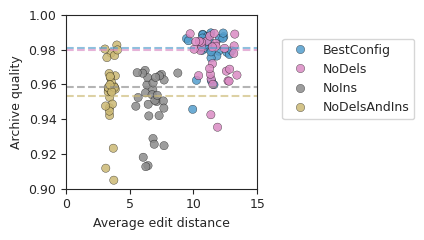

In [35]:
color_pallette = [sns.color_palette("Blues")[3]] + sns.color_palette("deep")[6:9]
draw_scatterplot(
    GRAMMAR_NODES_DF_LAST_GEN, 
    x="Archive_avg_edit_distance", 
    y="Archive_quality",
    xlabel="Average edit distance",
    ylabel="Archive quality",
    #title="Effect of removing grammar nodes",
    color_pallette=color_pallette,
    xlim=(0, 15),
    ylim=(0.9, 1.0),
    figsize=(4.5, 2.5),
    legend_outside=True,
    draw_horizontal_line=True,
    outfile='fig6_scatterplot_grammar_nodes.pdf'
) 

In [26]:
GRAMMAR_NODES_DF_LAST_GEN.query('Tag == "BestConfig"').Archive_avg_edit_distance.median()

11.32235

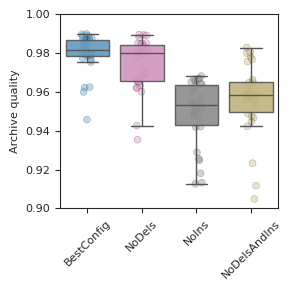

In [34]:
draw_boxplot(
    GRAMMAR_NODES_DF_LAST_GEN,
    x="Tag",
    y="Archive_quality",
    ylabel="Archive quality",
    color_pallette=color_pallette,
    do_statistical_test=False,
    ylim=(0.9, 1.0),
    figsize=(3, 3),
    include_xlabels=True,
    x_label_rotation=45
)

In [28]:
from dress.datasetgeneration.archive import Archive

tidy_data = []
for group, data in GRAMMAR_NODES_FULL_DATASETS.groupby('Tag'):

    no_dup = data.drop_duplicates(subset=['Sequence', 'Phenotype']).drop_duplicates('Sequence')
    bin_counts = Archive(dataset=no_dup).binarize()
    df = pd.DataFrame.from_dict(bin_counts, orient='index', columns=['Count']).reset_index(names='Bin')
    df['Tag'] = group
    tidy_data.append(df)

tidy_data = pd.concat(tidy_data, ignore_index=True)
tidy_data["Tag"] = pd.Categorical(
    tidy_data.Tag,
    categories=["BestConfig", "NoDels", "NoIns", "NoDelsAndIns"],
    ordered=True,
)

/tmp/ipykernel_1804624/3013360748.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


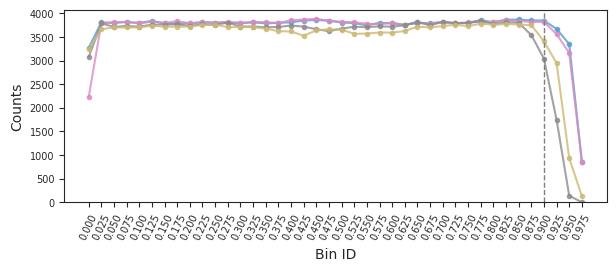

In [29]:
per_bin_filling_lineplot(
    tidy_data,
    color_pallette=color_pallette,
    draw_legend=False,
    outfile="fig6_counts_per_bin.pdf",
)

/tmp/ipykernel_1804624/780283628.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


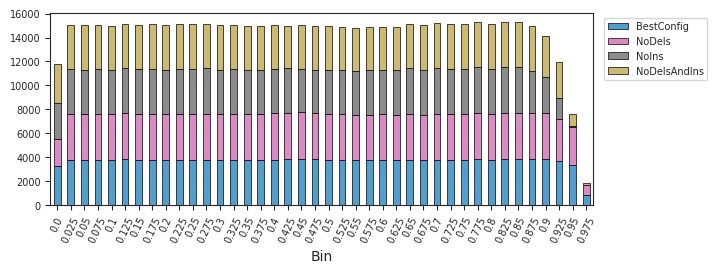

In [30]:
per_bin_filling_stacked_barplot(tidy_data, color_pallette=color_pallette)

/tmp/ipykernel_1804624/780283628.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


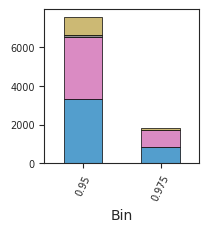

In [31]:
per_bin_filling_stacked_barplot(
    tidy_data, color_pallette=color_pallette, filter_by=0.94, draw_legend=False, figsize=(2,2)
)

## 4 - Generalization

Evaluate the capacity of the algorithm to generalize to other sequences. The dataset is composed by exons that were seen to be differentially spliced upon knockdown of RBFOX2, an RNA-binding protein that is known to be involved in alternative splicing.

#### Auxiliar information (original dPSI, sequence length, SpliceAI score of original sequence)

In [13]:
# dPSI
dpsi_df = pd.read_csv(
    "4_generalization/RBFOX2_knockdown/preprocessing_dPSI.tsv", sep="\t"
).rename(columns={"header_long": "Seq_id"})

# Original SpliceAI score
original_seqs = glob.glob("4_generalization/RBFOX2_knockdown/*_original_seq.csv")
dfs = []
for fn in original_seqs:
    df = pd.read_csv(fn)
    dfs.append(df)
original_seqs_df = pd.concat(dfs)[['Seq_id', 'Score']]

# Seq lengths
seqs = []
for id, seq in pyfaidx.Fasta(
    "4_generalization/RBFOX2_knockdown/preprocessing_sequences_trimmed_at_5000bp.fa"
).items():
    seqs.append([id, len(seq)])
seqs_df = pd.DataFrame(seqs, columns=["Seq_id", "Seq_len"])

dpsi_df = dpsi_df.merge(seqs_df).merge(original_seqs_df)
dpsi_df.rename(columns={'Score': 'SpliceAI_score'}, inplace=True)
dpsi_df['Run_id'] = dpsi_df.Seq_id.apply(lambda x: x.replace(':', '_').replace('(+)', '').replace('(-)', '').replace('-', '_'))
col_order = ['Run_id', 'Seq_id', 'exon', 'gene_name', 'dPSI', 'Seq_len', 'SpliceAI_score']
dpsi_df = dpsi_df[col_order]

#### Datasets

In [14]:
DATASETS_PATH = {
    "GGGP": "4_generalization/RBFOX2_knockdown",
    "RS": "4_generalization/RBFOX2_knockdown_randomSearch",
    "SQUID": "4_generalization/RBFOX2_knockdown_squid"
    }
archives = load_archive_checkpoints(
    list(DATASETS_PATH.values()),
    tags=list(DATASETS_PATH.keys()),
    seeds=(0, 5),
    just_last_generation=True,
).drop(columns='Run_id')

Reading directory:  4_generalization/RBFOX2_knockdown


Reading directory:  4_generalization/RBFOX2_knockdown_randomSearch
Reading directory:  4_generalization/RBFOX2_knockdown_squid


In [15]:
archives = archives.merge(dpsi_df, how="left", on="Seq_id")
avg_across_seed = (
    archives.groupby(["Tag", "Run_id", "dPSI", "Seq_len", "SpliceAI_score"])
    .agg({"Archive_quality": ["mean", "std"]})
    .reset_index()
)
avg_across_seed.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in avg_across_seed.columns]

In [16]:
blue = [sns.color_palette("Blues")[3]]
red = [sns.dark_palette((20, 60, 50), input="husl")[3]]
gold = [sns.color_palette("deep")[8]]
color_pallette = blue + red + gold

In [17]:
bins = [0, 2000, 4000, 6000, 8000, 10000, 12000]
labels = ["0-2kb", "2kb-4kb", "4kb-6kb", "6kb-8kb", "8kb-10kb", "10kb-12kb"]

avg_across_seed['Seq_len_range'] = pd.cut(avg_across_seed['Seq_len'], bins=bins, labels=labels)

In [18]:
avg_across_seed.groupby('Tag')['Archive_quality_mean'].mean()

Tag
GGGP     0.927471
RS       0.616287
SQUID    0.597606
Name: Archive_quality_mean, dtype: float64

In [19]:
avg_across_seed.groupby(['Tag', 'Seq_len_range'])['Archive_quality_mean'].agg(['count', 'mean', 'std'])

/tmp/ipykernel_1839147/1323136655.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


count      mean       std
Tag   Seq_len_range                           
GGGP  0-2kb             16  0.910003  0.107170
      2kb-4kb           24  0.916524  0.104713
      4kb-6kb           34  0.928926  0.087474
      6kb-8kb           35  0.942791  0.060890
      8kb-10kb          13  0.954582  0.053226
      10kb-12kb         22  0.909477  0.116554
RS    0-2kb             16  0.706866  0.089928
      2kb-4kb           24  0.731583  0.131004
      4kb-6kb           34  0.638618  0.114945
      6kb-8kb           35  0.562016  0.139107
      8kb-10kb          13  0.585840  0.097216
      10kb-12kb         22  0.494455  0.178817
SQUID 0-2kb             16  0.701500  0.067847
      2kb-4kb           24  0.677698  0.093905
      4kb-6kb           34  0.603022  0.079915
      6kb-8kb           35  0.551569  0.089103
      8kb-10kb          13  0.573155  0.066993
      10kb-12kb         22  0.513993  0.098480

#### Scatterplots

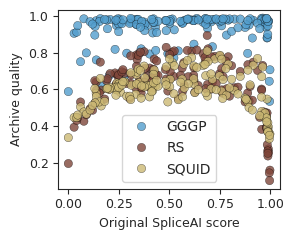

In [20]:
draw_scatterplot(avg_across_seed,
                 x='SpliceAI_score',
                 y='Archive_quality_mean',
                 hue='Tag',
                 xlabel='Original SpliceAI score',
                 ylabel='Archive quality',
                 alpha=0.8,
                 color_pallette=color_pallette,
                 )

In [55]:
diff_df = avg_across_seed.pivot(index='Run_id', columns=['Tag'], values='Archive_quality_mean')
diff_df['Diff_to_RS'] = diff_df.GGGP - diff_df.RS
diff_df['Diff_to_SQUID'] = diff_df.GGGP - diff_df.SQUID
diff_df = avg_across_seed.merge(diff_df.reset_index()[['Run_id', 'Diff_to_RS', 'Diff_to_SQUID']], on='Run_id').drop(columns=['Tag', 'Archive_quality_mean', 'Archive_quality_std']).drop_duplicates()
diff_df['Seq_len'] = diff_df.Seq_len.astype(float)

In [56]:
diff_df[diff_df.Diff_to_RS < 0]

,Run_id,dPSI,Seq_len,SpliceAI_score,Seq_len_range,Diff_to_RS,Diff_to_SQUID
69,chr13_51957416_51960422_ENST00000634844,-0.256,3007.0,0.4042,2kb-4kb,-0.03206,0.06422
147,chr19_804913_806656_ENST00000394601,-0.335,1744.0,0.2800,0-2kb,-0.01486,0.03142


In [57]:
diff_df[diff_df.Diff_to_SQUID < 0]

,Run_id,dPSI,Seq_len,SpliceAI_score,Seq_len_range,Diff_to_RS,Diff_to_SQUID


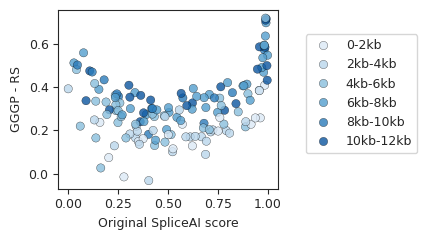

In [24]:
draw_scatterplot(diff_df,
                 x='SpliceAI_score',
                 y='Diff_to_RS',
                 hue='Seq_len_range',
                 xlabel='Original SpliceAI score',
                 ylabel='GGGP - RS',
                 alpha=0.8,
                 figsize=(4.5, 2.5),
                 legend_outside=True,
                 color_pallette='Blues',
                 outfile='fig7_generalization_spliceai_score.pdf'
                 )

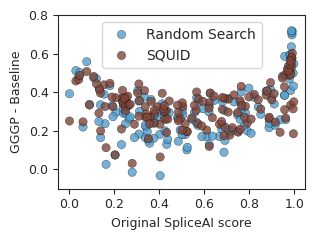

In [66]:
blue = [sns.color_palette("Blues")[3]]
red = [sns.dark_palette((20, 60, 50), input="husl")[3]]
gold = [sns.color_palette("deep")[8]]
color_pallette = blue + red
_diff_df = diff_df.melt(id_vars=['Run_id', 'dPSI', 'Seq_len', 'SpliceAI_score', 'Seq_len_range'], var_name='Tag', value_name='Diff')
_diff_df['Tag'] = _diff_df.Tag.str.replace('Diff_to_', '').str.replace('RS', 'Random Search')
draw_scatterplot(_diff_df,
                x='SpliceAI_score',
                y='Diff',
                hue='Tag',
                xlabel='Original SpliceAI score',
                ylim=(-0.1, 0.8),
                ylabel='GGGP - Baseline',
                alpha=0.8,
                figsize=(3.25, 2.5),
                legend_outside=False,
                color_pallette=color_pallette,
                outfile='fig7_generalization_spliceai_score.pdf'
                )               

#### Motifs

In [26]:
def extract_RBFOX2_counts(_df):
    rbp = 'RBFOX2'
    df = _df[_df.RBP_gained.str.contains(rbp, na=False) | _df.RBP_lost.str.contains(rbp, na=False)].copy()
    non_rbfox = _df[~(_df.RBP_gained.str.contains(rbp, na=False)) & ~(_df.RBP_lost.str.contains(rbp, na=False))].copy()
    def _parse_rbp(col):
        if pd.isna(col):
            return 0, ""
        rbfox = next((item for item in col.split(';') if rbp in item), None)
        if rbfox is None:
            return 0, ""
        n = int(rbfox.split('_x')[1]) if "_" in rbfox else 1
        return n, rbfox

    df[['N_gained', 'RBP_gained']] = df['RBP_gained'].apply(_parse_rbp).apply(pd.Series)
    df[['N_lost', 'RBP_lost']] = df['RBP_lost'].apply(_parse_rbp).apply(pd.Series)
    return df, non_rbfox

##### Load motif search summaries

In [27]:
DISRUPTION_EVENTS_PATH = {
    "GGGP": "4_generalization/3_motifs/GGGP_fimo_oRNAment",
    "RS": "4_generalization/3_motifs/RS_fimo_oRNAment",
    }

list_dfs = []
for strategy, path in DISRUPTION_EVENTS_PATH.items():
    dirs = os.listdir(path)

    for d in dirs:
        df = pd.read_csv(os.path.join(path, d, 'motifs/RBP_SUMMARY.tsv.gz'), sep='\t')
        df['Run_id'] = d
        df['Tag'] = strategy
        list_dfs.append(df)

motif_df = pd.concat(list_dfs)

##### Count frequency of motif disruption events (against the original sequence)

In [29]:
all_motifs_freq = motif_df.groupby(['Run_id', 'Tag']).apply(lambda x: (x[['N_gained', 'N_lost']].sum().sum()) / x.shape[0]).reset_index().rename(columns={0: 'all_freqs'})
pivot_all = all_motifs_freq.pivot(index='Run_id', columns='Tag', values='all_freqs')
pivot_all['Motifs Diff'] = pivot_all['GGGP'] - pivot_all['RS']
pivot_all = pivot_all.reset_index().drop(columns=['GGGP', 'RS'])

For RBFOX2 only

In [30]:
motif_df_rbfox2, non_rbfox = extract_RBFOX2_counts(motif_df)
non_rbfox['N_gained'] = 0
non_rbfox['N_lost'] = 0
motif_df_rbfox2 = pd.concat([motif_df_rbfox2, non_rbfox]).sort_values(['Run_id', 'Seq_id'])

/tmp/ipykernel_1839147/2820531578.py:14: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.


/tmp/ipykernel_1839147/2820531578.py:15: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.


In [31]:
rbfox2_freq = motif_df_rbfox2.groupby(['Run_id', 'Tag']).apply(lambda x: (x[['N_gained', 'N_lost']].sum().sum()) / x.shape[0]).reset_index().rename(columns={0: 'rbfox2_freq'})
pivot_rbfox2 = rbfox2_freq.pivot(index='Run_id', columns='Tag', values='rbfox2_freq')
pivot_rbfox2['RBFOX2 Diff'] = pivot_rbfox2['GGGP'] - pivot_rbfox2['RS']
pivot_rbfox2 = pivot_rbfox2.reset_index().drop(columns=['GGGP', 'RS'])

Merging all data

In [32]:
archives_all_freqs = archives.merge(pivot_all[['Run_id', 'Motifs Diff']], on='Run_id')
archives_all_freqs = archives_all_freqs.merge(pivot_rbfox2[['Run_id', 'RBFOX2 Diff']], on='Run_id')

In [33]:
# unch_threshold = 0.01
# chang_threshold = 0.1

In [34]:
# unchanged_motifs = motif_df[motif_df.Delta_score.abs() < unch_threshold]
# changed_motifs = motif_df[motif_df.Delta_score.abs() >= chang_threshold]

In [35]:
# chang_freq = changed_motifs.groupby(['Run_id', 'Tag']).apply(lambda x: (x['N_gained'] + x['N_lost']).sum() / x.shape[0]).reset_index().rename(columns={0: 'changed_ratio'})
# unch_freq = unchanged_motifs.groupby(['Run_id', 'Tag']).apply(lambda x: (x['N_gained'] + x['N_lost']).sum() / x.shape[0]).reset_index().rename(columns={0: 'noise_ratio'})
# merged_freqs = chang_freq.merge(unch_freq)
# merged_freqs['signal_to_noise'] = merged_freqs.changed_ratio / merged_freqs.noise_ratio

In [36]:
# pivot_all = merged_freqs.pivot(index='Run_id', columns='Tag', values='signal_to_noise')
# pivot_all['Motifs SNR Diff'] = pivot_all['GGGP'] - pivot_all['RS']
# pivot_all = pivot_all.reset_index().drop(columns=['GGGP', 'RS'])

For RBFOX2 only

In [37]:
# unchanged_motifs_rbfox2 = motif_df_rbfox2[motif_df_rbfox2.Delta_score.abs() < unch_threshold]
# changed_motifs_rbfox2 = motif_df_rbfox2[motif_df_rbfox2.Delta_score.abs() >= chang_threshold]

In [38]:
# chang_freq = changed_motifs_rbfox2.groupby(['Run_id', 'Tag']).apply(lambda x: (x['N_gained'] + x['N_lost']).sum() / x.shape[0]).reset_index().rename(columns={0: 'changed_ratio'})
# unch_freq = unchanged_motifs_rbfox2.groupby(['Run_id', 'Tag']).apply(lambda x: (x['N_gained'] + x['N_lost']).sum() / x.shape[0]).reset_index().rename(columns={0: 'noise_ratio'})
# merged_freqs_rbfox2 = chang_freq.merge(unch_freq)
# merged_freqs_rbfox2['signal_to_noise_rbfox2'] = merged_freqs_rbfox2.changed_ratio / merged_freqs_rbfox2.noise_ratio

In [39]:
# pivot_rbfox2 = merged_freqs_rbfox2.pivot(index='Run_id', columns='Tag', values='signal_to_noise_rbfox2')
# pivot_rbfox2['RBFOX2 SNR Diff'] = pivot_rbfox2['GGGP'] - pivot_rbfox2['RS']
# pivot_rbfox2 = pivot_rbfox2.reset_index().drop(columns=['GGGP', 'RS'])

Merging all data

In [40]:
# archives_snr = archives.merge(pivot_all[['Run_id', 'Motifs SNR Diff']], on='Run_id')
# archives_snr = archives_snr.merge(pivot_rbfox2[['Run_id', 'RBFOX2 SNR Diff']], on='Run_id')

#### Draw a complex heatmap with R 

In [41]:
# Install R within the conda environment
#%conda install -c r r-base -y
#%conda install -c conda-forge rpy2 -y

In [42]:
#%%R
# install.packages("dplyr")
# install.packages("tidyr")
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("ComplexHeatmap")

In [48]:
%reload_ext rpy2.ipython

In [49]:
%%R
library("ComplexHeatmap")
library("dplyr")
library("tidyr")
library("circlize")

In [50]:
%%R -i archives_all_freqs

#####################
## Data processing ##
#####################
motif_cols <- c('Motifs Diff', 'RBFOX2 Diff')

all_cols <- c(c('exon', 'Tag', 'Archive_quality', 'Seq_len', 'dPSI', 'SpliceAI_score'), motif_cols)
r_df <- as_tibble(archives_all_freqs) %>% dplyr::select(all_cols) %>% dplyr::mutate(exon = as.factor(exon))
mean_per_seed <- r_df %>% 
                group_by(exon, Tag) %>% 
                summarise(Archive_quality = mean(Archive_quality), 
                          Archive_Std = sd(Archive_quality))
                
r_df <- r_df %>% dplyr::select(-Archive_quality) %>% 
                distinct() %>% 
                left_join(mean_per_seed, by=c('exon', 'Tag')) %>% 
                arrange(exon)

# Pivoting
cols_subset <- c(c('exon', 'Seq_len', 'dPSI', 'SpliceAI_score'), motif_cols)
df_wide <- r_df %>%
  pivot_wider(
    id_cols = cols_subset,
    names_from = Tag, 
    values_from = c(Archive_quality, Archive_Std),
    names_sep = "_"
  )

# Bin by seq len
r_df <- df_wide %>% 
  mutate(Seq_len_range = cut(Seq_len, breaks = c(0, 2000, 4000, 6000, 8000, 10000, 12000), 
                             labels = c("0-2kb", "2kb-4kb", "4kb-6kb", "6kb-8kb", "8kb-10kb", "10kb-12kb"))) %>% 
  arrange(Seq_len)


r_df$Diff_to_RS <- r_df$Archive_quality_GGGP - r_df$Archive_quality_RS
r_df$Diff_to_SQUID <- r_df$Archive_quality_GGGP - r_df$Archive_quality_SQUID

`summarise()` has grouped output by 'exon'. You can override using the
`.groups` argument.


In [51]:
%%R
####################
### Heatmap ###
####################
#r_df <- r_df %>% dplyr::filter(Seq_len_range == "0-2kb")
set.seed(123)

quality_colors <- colorRampPalette(c("white", "darkblue"))(100)
dpsi_colors = colorRamp2(c(0, 1, 30), c("purple", "white", "yellow"))

# Main data
heatmap_matrix <- as.matrix(r_df %>% dplyr::select(c("Archive_quality_RS", "Archive_quality_SQUID", "Archive_quality_GGGP")))
row.names(heatmap_matrix) <- r_df$exon
colnames(heatmap_matrix) <- c("RS", "SQUID", "GGGP")

# Row split by seq len
level_order = c("0-2kb", "2kb-4kb", "4kb-6kb", "6kb-8kb", "8kb-10kb", "10kb-12kb")
r_df$Seq_len_range <- factor(r_df$Seq_len_range, 
                             levels = level_order)
row_split <- r_df$Seq_len_range

# HeatmapAnnotation object for difference in quality
diff_point_annotation_to_RS <- rowAnnotation(
    `GGGP - RS` = anno_points(r_df$Diff_to_RS, 
                       pch = 16, # solid circle
                       gp = gpar(col = ifelse(r_df$Diff_to_RS > 0, "cadetblue", "cornsilk3"), bg=2, size=0.5, lwd = 0.5),
                       width = unit(2, "cm"), 
                       axis_param = list(
                            labels_rot = 45
                        )
    )
)
diff_point_annotation_to_SQUID <- rowAnnotation(
    `GGGP - SQUID` = anno_points(r_df$Diff_to_SQUID, 
                       pch = 16, # solid circle
                       gp = gpar(col = ifelse(r_df$Diff_to_SQUID > 0, "cadetblue", "cornsilk3"), bg=2, size=0.5, lwd = 0.5),
                       width = unit(2, "cm"), 
                       axis_param = list(
                            labels_rot = 45
                        )
    )
)
diff_legend =  Legend(labels = c("<= 0", "> 0"), 
                       legend_gp = gpar(col = c("cornsilk3", "cadetblue")),
                       title = "Archive quality difference",
                       type = "points",
                       pch = 16)

# HeatmapAnnotation object for motif signal to noise ratio
target_col <- motif_cols[[1]]
all_motifs_point_annotation <- rowAnnotation(
    `Motifs Diff` = anno_points(r_df[[target_col]], 
                       pch = 16, # solid circle
                       gp = gpar(col = ifelse(r_df[[target_col]] > 0, "coral4", "cornsilk3"), bg=2, size=0.5, lwd = 0.5),
                       width = unit(2, "cm"), 
                       axis_param = list(
                            labels_rot = 45
                        )
    )
)

num_le_0 = sum(r_df[[target_col]] <= 0)
num_gt_0 = sum(r_df[[target_col]] > 0)
labels = c(paste("<= 0 (N=", num_le_0, ")", sep=""), paste("> 0 (N=", num_gt_0, ")", sep=""))

all_motifs_legend =  Legend(labels = labels, 
                       legend_gp = gpar(col = c("cornsilk3", "coral4")),
                       title = "Motifs frequency difference (GGGP - RS)",
                       type = "points",
                       pch = 16)


# # HeatmapAnnotation object for RBFOX2 only
# target_col <- motif_cols[[2]]
# rbfox2_point_annotation <- rowAnnotation(
#     `RBFOX2 Diff` = anno_points(r_df[[target_col]], 
#                        pch = 16, # solid circle
#                        gp = gpar(col = ifelse(r_df[[target_col]] > 0, "darkblue", "cornsilk3"), bg=2, size=0.5, lwd = 0.5),
#                        width = unit(2, "cm"), 
#                        axis_param = list(
#                             labels_rot = 45
#                         )
#     )
# )

# num_le_0 = sum(r_df[[target_col]] <= 0)
# num_gt_0 = sum(r_df[[target_col]] > 0)
# labels = c(paste("<= 0 (N=", num_le_0, ")", sep=""), paste("> 0 (N=", num_gt_0, ")", sep=""))
# rbfox2_legend =  Legend(labels = labels, 
#                        legend_gp = gpar(col = c("cornsilk3", "darkblue")),
#                        title = "RBFOX2 Diff (GGGP - RS)",
#                        type = "points",
#                        pch = 16)


# HeatmapAnnotation object for dPSI
# dpsi_col_fun <- colorRamp2(c(min(r_df$dPSI, na.rm = TRUE), 
#                              max(r_df$dPSI, na.rm = TRUE)), 
#                            c("blue", "red"))


# dpsi_barplot_annotation <- rowAnnotation(
#             dPSI = anno_barplot(r_df$dPSI, 
#                                 col = dpsi_col_fun, 
#                                 border = FALSE,
#                                 width = unit(3, "cm"),
#                                 gp = gpar(lwd = 1, border=TRUE, col = 'black', fill="salmon"),
#                                 axis_param = list(labels_rot = 45)
#     )
#         )


# HeatmapAnnotation object for raw SpliceAI score
# spliceai_point_annotation <- rowAnnotation(
#     `SpliceAI score` = anno_points(r_df$SpliceAI_score, 
#                        pch = 16,
#                        gp = gpar(col = "bisque3", bg=2, size=0.5, lwd = 0.5),
#                        width = unit(2, "cm"), 
#                        axis_param = list(
#                             labels_rot = 45
#                         )
#     )
# )

ht_obj <- Heatmap(heatmap_matrix, 
        name = "Archive quality", 
        col = quality_colors,
        show_row_names = FALSE, 
        column_names_rot = 0, 
        column_names_side = "bottom",
        rect_gp = gpar(col = "black", lwd = 1e-10),
        column_names_gp = gpar(fontsize = 12, just = "center"),
        cluster_columns = FALSE,
        column_title = NULL,
        row_split = row_split, 
        cluster_row_slices = FALSE,
        cluster_rows = TRUE, 
        row_title_rot = 0,
        row_gap = unit(3, "mm"),
        border = TRUE,
        width = unit(2, "cm"),
        show_heatmap_legend = FALSE,
        #height = unit(20, "cm"),
        right_annotation = diff_point_annotation_to_RS
)


ht_drawn <- draw(ht_obj)
default_legend <- color_mapping_legend(ht_drawn@ht_list[[1]]@matrix_color_mapping, plot = FALSE)
ht_combined <- ht_obj
ht_combined <- ht_obj + diff_point_annotation_to_SQUID + all_motifs_point_annotation # + rbfox2_point_annotation
#ht_combined <- ht_obj + spliceai_point_annotation + dpsi_barplot_annotation

pdf("fig7_generalization_heatmap.pdf", width = 6.5, height = 5.5)

lgd_list <- list(default_legend, diff_legend, all_motifs_legend)#, rbfox2_legend)
draw(ht_combined, annotation_legend_list = lgd_list)
dev.off()


png 
  2 
